In [114]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [115]:
import matplotlib.pyplot as plt 
%matplotlib inline
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [170]:
emotion = pd.read_csv('emotion_dataset.csv')
emotion.head(1)

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포


In [171]:
emotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB


## 오류 해결 : Emotion 의 Dtype이 int가 아닌 object임을 확인
* 라벨링 단계에서 직접 데이터를 감정별로 분리하여 라벨을 숫자형으로 입력시킨 뒤 감정 데이터를 취합함

## 전처리

In [118]:
emotion 

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
38590,재미가 없으니 망하지,혐오
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


In [172]:
emotion['Sentence'] = emotion['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
emotion[:5]

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,공포
1,그냥 내 느낌일뿐겠지,공포
2,아직너무초기라서 그런거죠,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [173]:
emotion['Sentence'] = emotion['Sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
emotion['Sentence'].replace('', np.nan, inplace=True)
print(emotion.isnull().sum())

Sentence    2
Emotion     0
dtype: int64


In [175]:
emotion[emotion['Sentence'].isnull()]

,Sentence,Emotion
10149,NaN,놀람
31822,NaN,행복


In [176]:
emotion = emotion.dropna(how = 'any')
print('전처리 후 데이터의 개수 :',len(emotion))

전처리 후 데이터의 개수 : 38592


## 데이터 라벨링

In [177]:
emotion.loc[(emotion['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
emotion.loc[(emotion['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
emotion.loc[(emotion['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
emotion.loc[(emotion['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
emotion.loc[(emotion['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
emotion.loc[(emotion['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
emotion.loc[(emotion['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

In [ ]:
## 시도 1 astype()으로 변경

In [178]:
emotion.Emotion = emotion.Emotion.astype(int)

In [179]:
emotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38592 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38592 non-null  object
 1   Emotion   38592 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 753.8+ KB


In [180]:
emotion.Emotion.unique()

array([0, 1, 2, 3, 4, 5, 6])

---

In [ ]:
## 시도 2 하나씩 분리해서 다시 append

In [126]:
fear = emotion[emotion['Emotion'] == 0]
fear['Emotion'] = 0

In [127]:
sur = emotion[emotion['Emotion'] == 1]
sur['Emotion'] = 1

In [128]:
ang = emotion[emotion['Emotion'] == 2]
ang['Emotion'] = 2
sad = emotion[emotion['Emotion'] == 3]
sad['Emotion'] = 3
neu = emotion[emotion['Emotion'] == 4]
neu['Emotion'] = 4
joy = emotion[emotion['Emotion'] == 5]
joy['Emotion'] = 5
hat = emotion[emotion['Emotion'] == 6]
hat['Emotion'] = 6

In [129]:
emotion = fear.append(sur)

In [130]:
emotion = emotion.append(ang)
emotion = emotion.append(sad)
emotion = emotion.append(neu)
emotion = emotion.append(joy)
emotion = emotion.append(hat)

---

In [181]:
emotion.shape

(38592, 2)

In [132]:
# print(data_list[0])
# print(data_list[6000])
# print(data_list[12000])
# print(data_list[18000])
# print(data_list[24000])
# print(data_list[30000])
# print(data_list[-1])

## 오류해결 step2 : 데이터 타입이 int로 변경되었음을 확인

In [182]:
emotion.reset_index(drop=True,inplace=True)

In [183]:
type(emotion['Emotion'].iloc[0])

numpy.int32

## 데이터 분리

In [184]:
train_data, test_data = train_test_split(
  emotion,
  test_size = 0.25,
  random_state = 5
)

In [185]:
train_data.head(3)

,Sentence,Emotion
8793,진짜 많은 사람들앞에서 실제로 손님이 있다고치고 연습하나요,1
5134,남자친구한테 기대지않으려면 어떻게해야할까요,0
1440,유투브 땅굴 발견 전쟁임박,0


In [186]:
 # 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '우리','다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']

In [138]:
# 학습 데이터
X_train = []
for sentence in tqdm(train_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 28944/28944 [00:49<00:00, 589.81it/s]


In [139]:
# 테스트 데이터 
X_test = []
for sentence in tqdm(test_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 9648/9648 [00:17<00:00, 563.02it/s]


In [140]:
X_train[:1]

[['진짜', '많다', '사람', '앞', '실제', '로', '손님', '연습', '하나요']]

## 정답 데이터 저장

In [141]:
y_train = np.array(train_data['Emotion'])
y_test = np.array(test_data['Emotion'])

In [142]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(drop_train)

[6145, 6853, 7993, 8338, 9141, 17672, 18777, 20080, 20274, 28235]


In [143]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

28934
28934
9648
9648
9640
9640


## 정수 인코딩

In [144]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [28]:
# print(tokenizer.word_index)
# print(tokenizer.word_counts.items())

In [145]:
print(X_train[:1])

[list(['진짜', '많다', '사람', '앞', '실제', '로', '손님', '연습', '하나요'])]


## 빈도수 확인

In [146]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [147]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 19774
등장 빈도가 2번 이하인 희귀 단어의 수: 12449
단어 집합에서 희귀 단어의 비율: 62.95640740366137
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.144362146026966


In [148]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7326


In [149]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 정수 인코딩 확인

In [150]:
print(X_train[:1])

[[9, 33, 14, 131, 982, 10, 1129, 1552, 747]]


## 패딩

문장의 최대 길이 : 112
문장의 평균 길이 : 5.9876961360337315


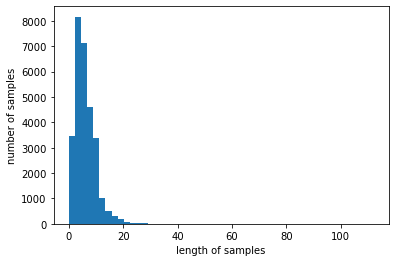

In [151]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [152]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [153]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 99.50577175641115


## 모든 샘플의 길이를 max_len로 조정

In [154]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [155]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  729,  164,   16, 2125,  269,  126])

## 모델 적용

In [156]:
import numpy as np

In [157]:

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Embedding, Bidirectional,TimeDistributed
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
# 결과값 seq to seq : many to many

In [27]:
# model = Sequential()
# model.add(Embedding(vocab_size, 300, mask_zero=True))
# model.add(Bidirectional(LSTM(128)))
# model.add(Dense(64,activation="relu"))
# model.add(Dense(32,activation="relu"))
# model.add(Dense(16,activation="relu"))
# model.add(Dense(7,activation='sigmoid')) # , activation='sigmoid'

## 적용 
다중 분류 모델이므로
* `softmax`
* 7가지 감정
* loss는 `binary_crossentropy`가 아닌  `sparse_categorical_crossentropy`로 compile

### softmax , 7 , sparse_categorical_crossentropy

## 오류 [211202] LSTM 감정분류 모델 적용 이슈 # 32
NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [111]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(7,activation='softmax')) # , activation='sigmoid'

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [112]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [113]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15


InvalidArgumentError:  assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [64 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [64 15]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-113-041bf72dd81d>:2) ]] [Op:__inference_train_function_1578]

Function call stack:
train_function


---

## 이중 분류에서 사용되었던 예측 함수

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 문장입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 문장입니다.\n".format((1 - score) * 100))

---

## 다중 분류 예측 함수 과정

In [ ]:
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', '진짜 많은 사람들앞에서 실제로 손님이 있다고치고 연습하나요')
new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
score = model.predict(pad_new) # 예측

In [ ]:
print(score)

In [ ]:
float(score[0][])

In [ ]:
score[0].sum()

In [ ]:
score[0].max()

In [ ]:
score[0][0]

In [ ]:
if score[0][0] == score[0].max():
    print(f"{round(score[0][0] * 100,2)} 확률로 공포 문장입니다.\n")
elif score[0][1] == score[0].max():
    print(f"{round(score[0][1] * 100,2)} 확률로 놀람 문장입니다.\n")
elif score[0][2] == score[0].max():
    print(f"{round(score[0][2] * 100,2)} 확률로 분노 문장입니다.\n")
elif score[0][3] == score[0].max():
    print(f"{round(score[0][3] * 100,2)} 확률로 슬픔 문장입니다.\n")
elif score[0][4] == score[0].max():
    print(f"{round(score[0][4] * 100,2)} 확률로 중립 문장입니다.\n")
elif score[0][5] == score[0].max():
    print(f"{round(score[0][5] * 100,2)} 확률로 행복 문장입니다.\n")
elif score[0][6] == score[0].max():
    print(f"{round(score[0][6], * 100,2)} 확률로 혐오 문장입니다.\n")

In [49]:
model = tf.keras.models.load_model('models/biLSTM_w2v_1126.h5')

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_20/forward_lstm_24/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [37]:
def multi_sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = model.predict(pad_new) # 예측
    if score[0][0] == score[0].max():
        print(f"{round(score[0][0] * 100,2)} 확률로 공포 문장입니다.\n")
    elif score[0][1] == score[0].max():
        print(f"{round(score[0][1] * 100,2)} 확률로 놀람 문장입니다.\n")
    elif score[0][2] == score[0].max():
        print(f"{round(score[0][2] * 100,2)} 확률로 분노 문장입니다.\n")
    elif score[0][3] == score[0].max():
        print(f"{round(score[0][3] * 100,2)} 확률로 슬픔 문장입니다.\n")
    elif score[0][4] == score[0].max():
        print(f"{round(score[0][4] * 100,2)} 확률로 중립 문장입니다.\n")
    elif score[0][5] == score[0].max():
        print(f"{round(score[0][5] * 100,2)} 확률로 행복 문장입니다.\n")
    elif score[0][6] == score[0].max():
        print(f"{round(score[0][6] * 100,2)} 확률로 혐오 문장입니다.\n")

In [ ]:
multi_sentiment_predict('유치원버스 사고 낫다던데')

In [ ]:
multi_sentiment_predict('유투브 땅굴 발견 전쟁임박')

In [ ]:
multi_sentiment_predict('근데 원래이런거맞나요')

In [ ]:
multi_sentiment_predict('적막한 밤하늘 내 맘에도 드리우면 난 늘 그대가 보고 싶곤 해')

In [ ]:
multi_sentiment_predict('너의 웃음소리 참 듣기가 좋아')

In [ ]:
multi_sentiment_predict('그대와 나 이별하던 그날 그 아침 나는 울지 않았소')

In [ ]:
multi_sentiment_predict('나 그댈 위해 시 한 편을 쓰겠어')

In [ ]:
multi_sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯')

In [523]:
multi_sentiment_predict('창가에 요란히 내리는 빗물 소리만큼')

33.72 확률로 슬픔 문장입니다.



In [524]:
multi_sentiment_predict('창가에 요란히 내리는 빗물 소리만큼 시린 기억들')

TypeError: round() argument after * must be an iterable, not int